# Convolutional Neural Network MNIST

### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from pytorch_training import train_model

### Transform

In [2]:
# It is known for this dataset but we can also calculate it by looping through the dataset
mean_gray = 0.1307
stddev_gray = 0.3081

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_gray,), (stddev_gray,))
])

### Dataset

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

### Plotting

Label: 4


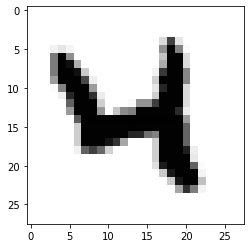

In [4]:
plt.imshow(train_dataset[20][0].numpy().squeeze(), cmap='gray_r')
print('Label:', train_dataset[20][1])

### Data Loader

In [5]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [6]:
class CNNMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)   
        self.conv2 = nn.Conv2d(8, 32, 5, 1, 2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(7*7*32, 600)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(600, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # Flatten
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

### Model Object

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNNMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training

In [8]:
metrics = train_model(15, model, criterion, optimizer, train_loader, test_loader, device)

  0%|          | 0/15 [00:00<?, ?epochs/s]

Epoch 01/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 02/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 03/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 04/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 05/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 06/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 07/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 08/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 09/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 10/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 11/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 12/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 13/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 14/15:   0%|          | 0/700 [00:00<?, ?batches/s]

Epoch 15/15:   0%|          | 0/700 [00:00<?, ?batches/s]

### Plot Result

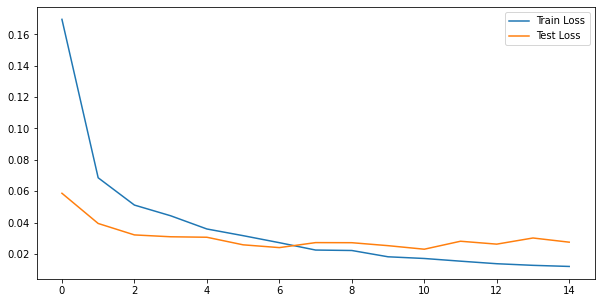

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(metrics["train_loss"], label='Train Loss')
plt.plot(metrics["test_loss"], label='Test Loss')
plt.legend()
plt.show()

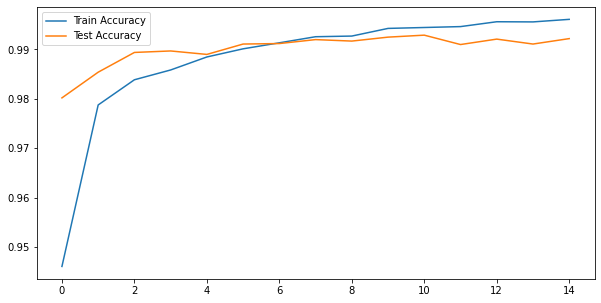

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(metrics["train_accuracy"], label='Train Accuracy')
plt.plot(metrics["test_accuracy"], label='Test Accuracy')
plt.legend()
plt.show()

In [11]:
img = test_dataset[30][0].reshape(1, 1, 28, 28).to(device)
label = test_dataset[30][1]
model.eval()
output = model(img)

Actual: 3
Predicted: 3


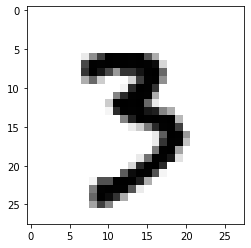

In [12]:
plt.imshow(img.cpu().numpy().squeeze(), cmap='gray_r')
print('Actual:', label)
print('Predicted:', torch.max(output.data, 1)[1].item())

### Classify Own Image

In [13]:
def predict(img_dir, model):
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (28, 28), interpolation=cv2.INTER_AREA)
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    img = Image.fromarray(image)
    img = transform(img)
    img = img.reshape(1, 1, 28, 28).to(device)
    plt.imshow(img.cpu().numpy().squeeze(), cmap='gray_r')
    plt.show()
    model.eval()
    output = model(img)
    print('Predicted:', torch.max(output.data, 1)[1].item())

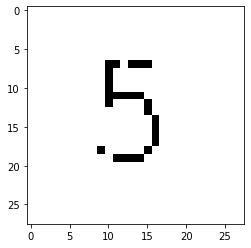

Predicted: 5


In [14]:
predict("./data/mnist_test.png", model=model)